# **Projekt: Fehlererkennung in Getrieben**
## Netztyp 2: FFT-Net
### Preprocessing

#### **Vorbereitung**

In [1]:
# import libraries
import numpy as np
from uuid import uuid4
from random import randint
import os
from pandas import DataFrame
from pathlib import Path

# module imports from /src
if Path.cwd().stem == "notebooks":
    os.chdir( Path.cwd().parent)
    
import src.preprocessing_v2 as pre
import src.data_loader_v2 as dl
import src.visualization as vis
import src.model_constructor as mc

In [2]:
# boolean values to control the program flow
TESTING: bool = False
DOWNLOAD: bool = False

# setup a single index for control of preprocessing steps
CONTROL_INDEX: int = 4 #randint(0,9)

In [3]:
# generate a unique identifier for this run
UUID: str = str(uuid4())

In [4]:
# setup system and check the number of cpu cores and gpus available
mc.system_setup()

Number of CPU cores:		20
Number of GPUs available:	0


#### **Laden der Datensätze**

In [5]:
if DOWNLOAD:
    
    # download full dataset from kaggle
    dl.fetch_kaggle_dataset(dl.DATASET_ADDRESS)

In [6]:
if not TESTING:
    
    # load data from folder and split in training and evaluation data
    data_path = Path().cwd() / "data" / "raw"
    development_data, evaluation_data = dl.load_all_datasets(data_path)
    all_datasets = development_data + evaluation_data

else:

    # program testing set
    test = dl.load_dataset(Path("./data/raw/1D.csv"))

READING TRAINING DATA
0D.csv successfully loaded.
1D.csv successfully loaded.
2D.csv successfully loaded.
3D.csv successfully loaded.
4D.csv successfully loaded.
READING EVALUATION DATA
0E.csv successfully loaded.
1E.csv successfully loaded.
2E.csv successfully loaded.
3E.csv successfully loaded.
4E.csv successfully loaded.
READING COMPLETED


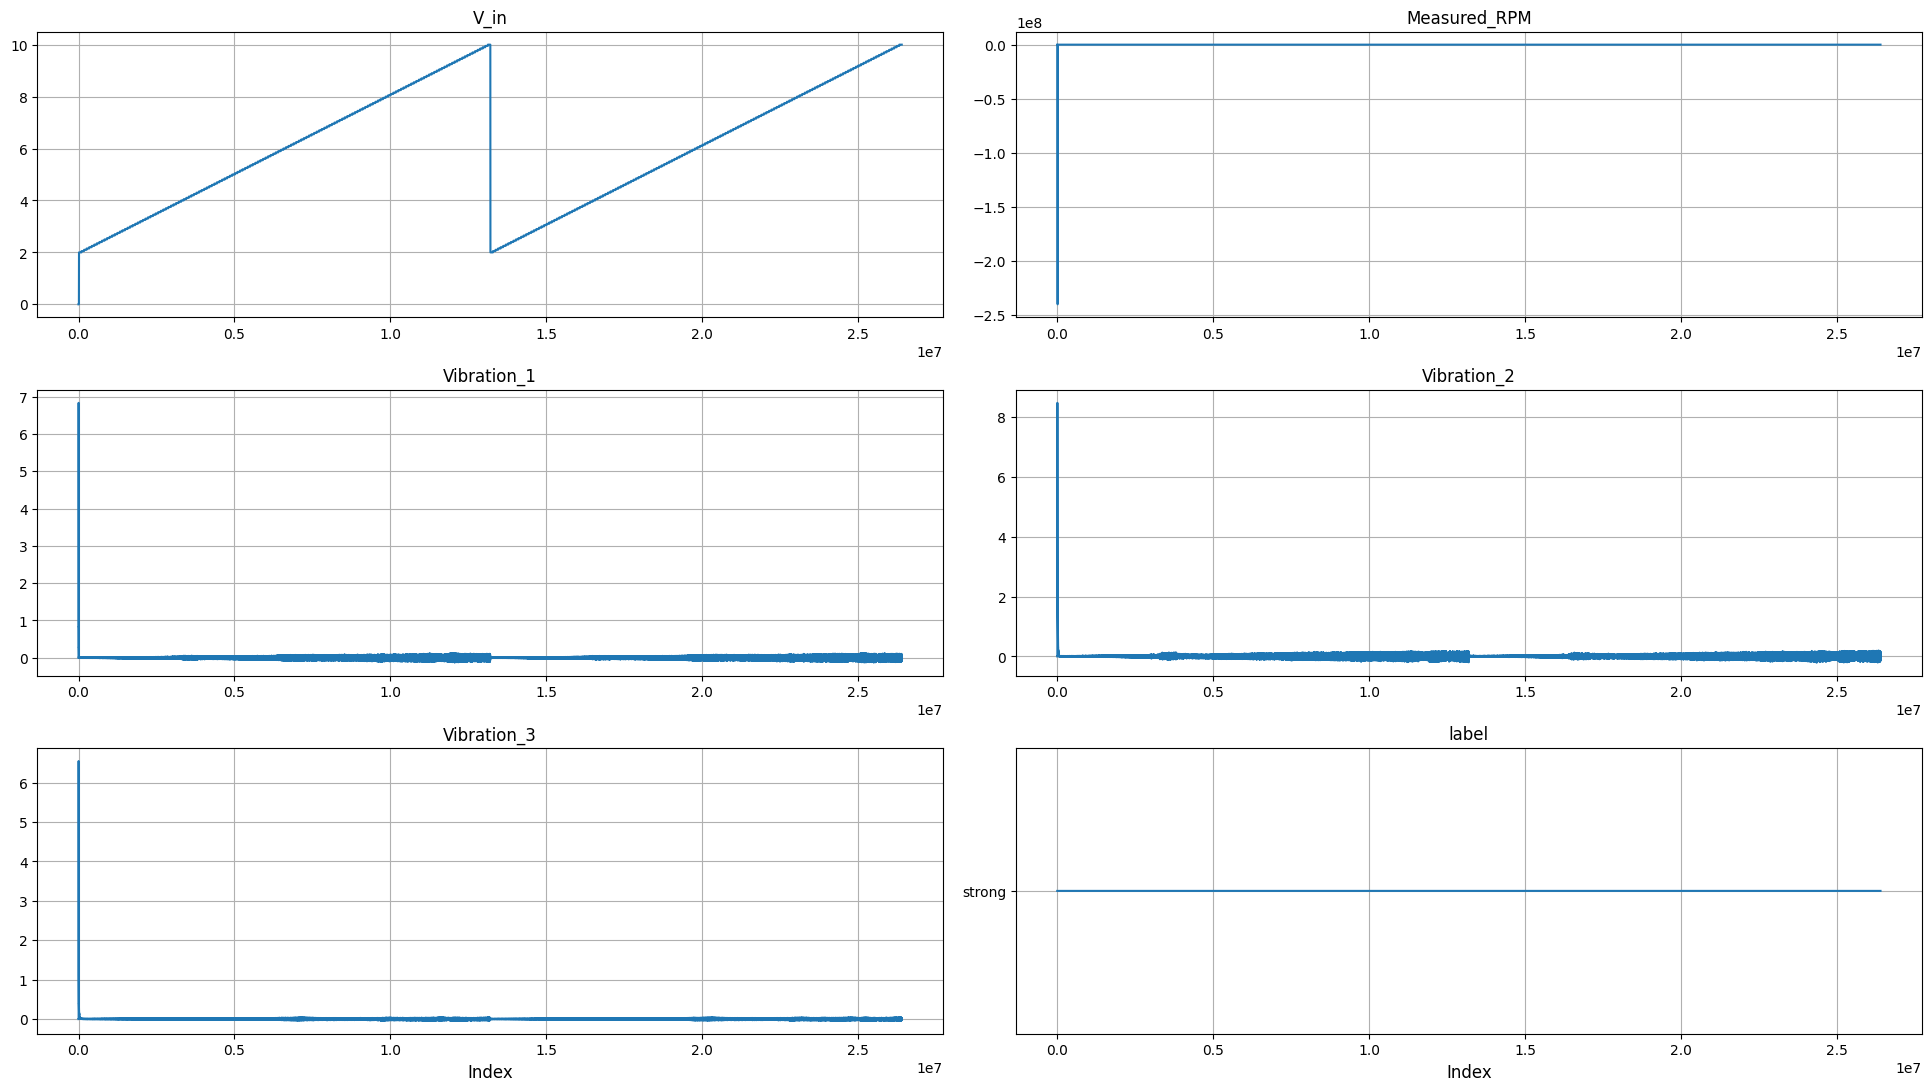

In [7]:
if not TESTING:
    
    # visualize one random dataset for data validation
    vis.plot_columns_as_subplots(all_datasets[CONTROL_INDEX], all_datasets[CONTROL_INDEX].columns)

else:

    # visualize the program testing set
    vis.plot_columns_as_subplots(test, test.columns)

#### **Preprocessing**

##### **Bereinigung der Daten**
Jeder Datensatz beginnt mit negativen Spitzen in den V_in und den Measured_RPM. Tresholding einer der beiden Messreihen entfernt diese Fehler im jeweiligen Datensatz. Durch Anpassung der Indizes beginnt jeder Datensatz mit Index 0.

In [8]:
if not TESTING:

    for dataset in all_datasets:
        pre.apply_threshold(dataset, threshold=0, column="V_in", mode="le", reset_index=True)

else:
    
    pre.apply_threshold(test, threshold=0, column="V_in", mode="le", reset_index=True)

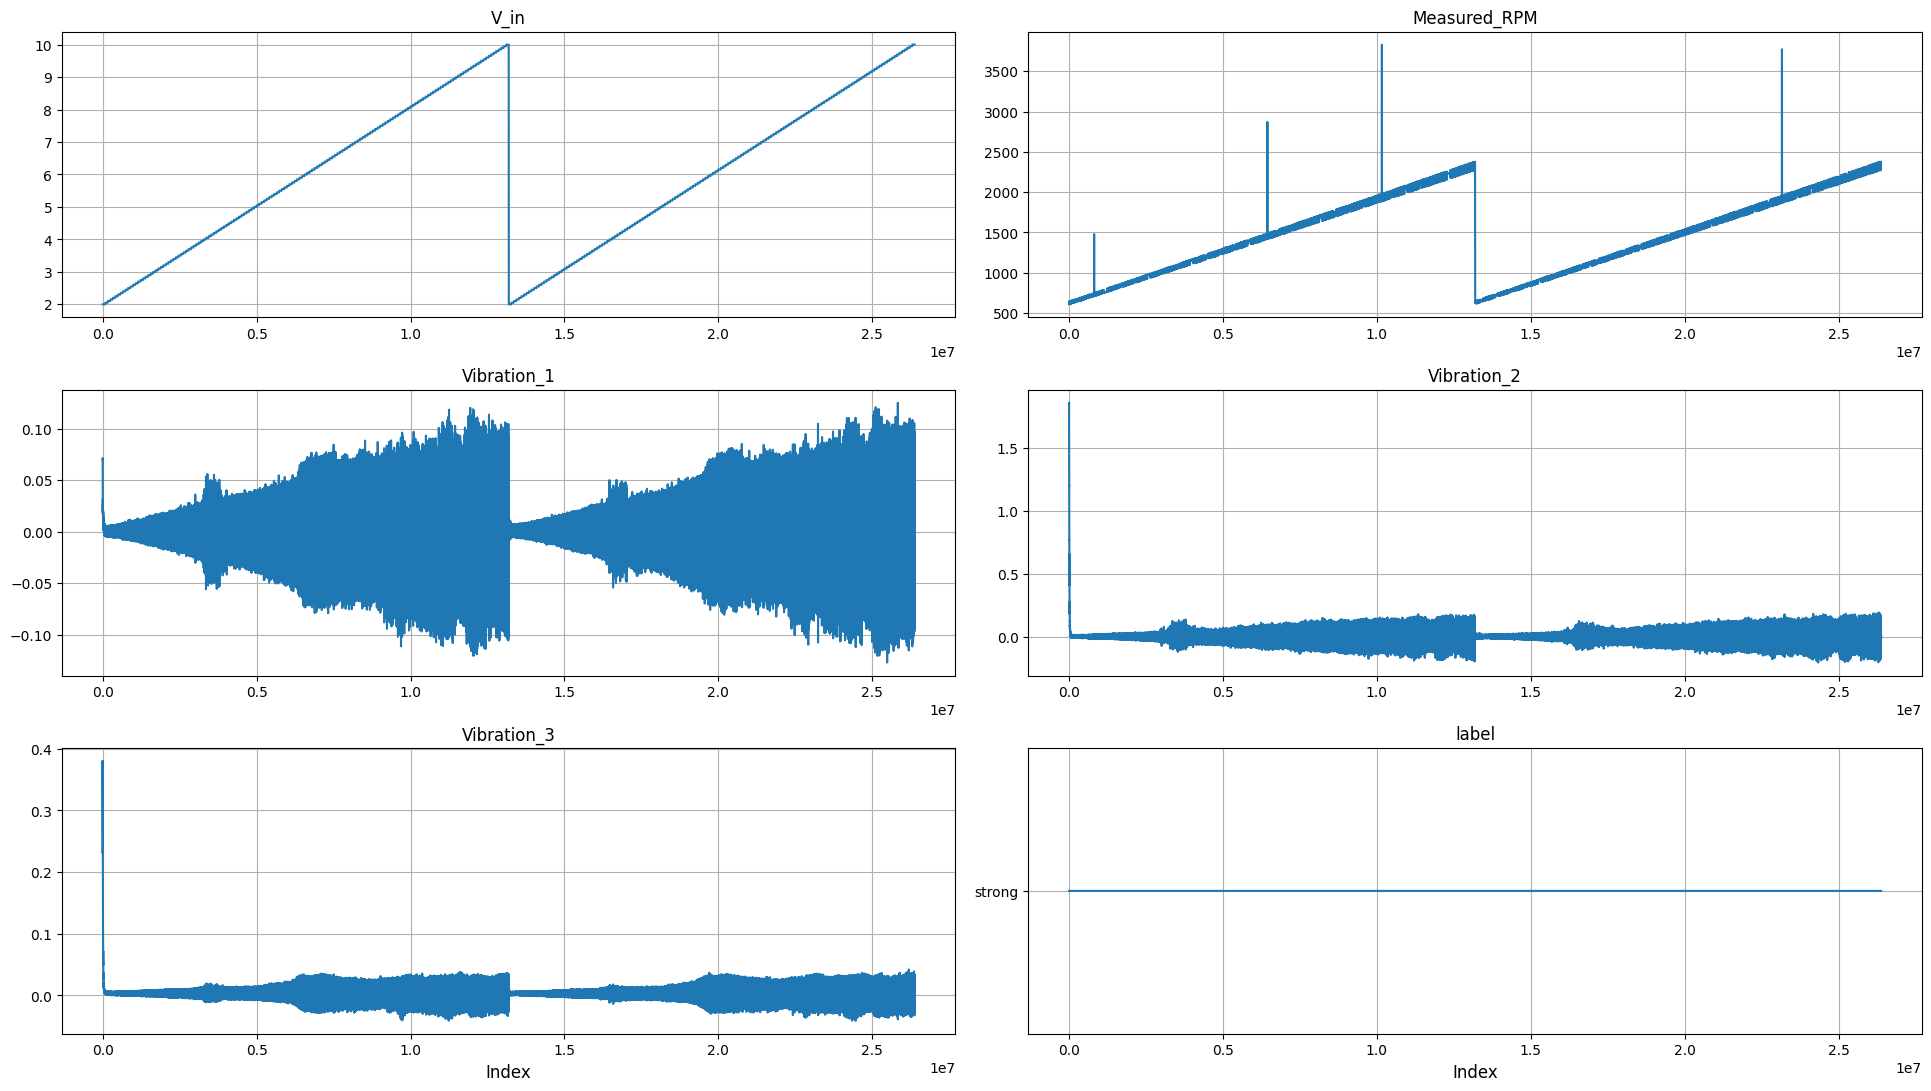

In [9]:
if not TESTING:

    # visualize one random dataset for data validation
    vis.plot_columns_as_subplots(all_datasets[CONTROL_INDEX],
                                 all_datasets[CONTROL_INDEX].columns)
    
else:

    # visualize the program testing set
    vis.plot_columns_as_subplots(test, test.columns)

##### **Fast Fourier Transformation**
Eine Fast Fourier Transformation (FFT) über führt die Daten eines ausgewählten Sensors vom Zeit- in den Frequenzbereich. Sie verwendet ein Fenster von einer Sekunde bzw. $n=4096$ Messwerten. Mey et al. verwenden in ihrer Arbeit die ersten 2048 Fourier-Koeffizienten. Diese sind der *Zero Frequency Term* bei $0 \times f_s$, die Summe des Signals, und die 2047 positiven Frequenzanteile (*frequency components*). NumPy bietet zur Berechnung der positiven Frequenzanteile die *Real FFT* numpy.rfft(), die in diesem Projekt implementiert ist. Pro Sekunde des ursprünglichen Datensatzes generiert die FFT somit 2048 Frequenzanteile. Aufgrund der Halbierung der Anzahl von Messwerten, speichert ein neues Dataset die Fourier-Koeffizienten. 

$$A_k = \frac{1}{n} \cdot \sum^{n-1}_{m=0} a_m \cdot e^{-2\,\pi\,i\,\frac{m\,k}{n}} \qquad \text{mit} \qquad a_m = e^{2\,\pi\,i\,m\,f\,\Delta t} \quad \text{und} \quad k = 0,~\dots,~n-1$$

Für eine spätere Zuordnung wird mit derselben Fenstergröße der Median der Drehzahlen berechnet. Das Label des ursprünglichen Datensatzes wird in das neue Dataset übertragen.

In [10]:
SENSOR: int = 1

if not TESTING:

    for index, dataset in enumerate(all_datasets):
        # calculate fft frequencies and magnitudes alongside the median rpms
        fft_frequencies, fft_magnitudes = pre.calculate_fft_magnitudes(dataset, column=f"Vibration_{SENSOR}", normalize=False)
        rpms = pre.median(dataset, column="Measured_RPM", stretch=True)
        # empty the dataset and add the new data
        dataset_attributes = dataset.attrs
        dataset = DataFrame({"rpm": rpms[::2],
                             "fft_frequency": fft_frequencies,
                             "fft_magnitude": fft_magnitudes,
                             "label": dataset_attributes["unbalance"]}
                             )
        dataset.attrs = dataset_attributes
        all_datasets[index] = dataset

else:
    
    fft_frequencies, fft_magnitudes = pre.calculate_fft_magnitudes(test, column=f"Vibration_{SENSOR}", normalize=False)
    rpms = pre.median(test, column="Measured_RPM", stretch=True)
    transformed_test = DataFrame({"rpm": rpms[::2],"fft_frequency": fft_frequencies, "fft_magnitude": fft_magnitudes})
    transformed_test.attrs = test.attrs
    transformed_test["label"] = transformed_test.attrs["unbalance"]

In [11]:
if not TESTING:

    # describe one random dataset for data validation
    display(all_datasets[CONTROL_INDEX].describe())

else:
    
    # program testing set
    display(transformed_test.describe())

,rpm,fft_frequency,fft_magnitude
count,1.318707e+07,1.318707e+07,1.318707e+07
mean,1.481077e+03,1.023500e+03,4.131436e-01
std,4.946013e+02,5.912066e+02,7.813680e-01
min,6.077825e+02,0.000000e+00,8.787723e-06
25%,1.052604e+03,5.117500e+02,5.142199e-02
50%,1.477305e+03,1.023500e+03,1.615732e-01
75%,1.905862e+03,1.535250e+03,4.622576e-01
max,3.830089e+03,2.047000e+03,1.583333e+02


##### **Robust Scaling**

Robust Scaling entfernt aus der Messreihe $X$ 

Interquantilabstand (*Inter-Quantile Range*, IRQ) zwischen dem 5%-Quantil $x_{0.05}$ und dem 95%-Quantil $x_{0.95}$.

$$x^*_i = \frac{x_i - \text{median}~{X}}{x_{0.95} - x_{0.05}} \qquad \text{mit} \qquad X=\{x_0,~x_1,~\dots,~x_n-1\}$$

In [12]:
if not TESTING:

    for index, dataset in enumerate(all_datasets):
        all_datasets[index] = pre.scale_robust(dataset, column="fft_magnitude")

else:
    
    transformed_test = pre.scale_robust(transformed_test, column="fft_magnitude")

In [13]:
if not TESTING:

    # describe one random dataset for data validation
    display(all_datasets[CONTROL_INDEX].describe())

else:
    
    # program testing set
    display(transformed_test.describe())

,rpm,fft_frequency,fft_magnitude
count,1.318707e+07,1.318707e+07,1.318707e+07
mean,1.481077e+03,1.023500e+03,1.382678e-01
std,4.946013e+02,5.912066e+02,6.625349e-01
min,6.077825e+02,0.000000e+00,-2.938059e-01
25%,1.052604e+03,5.117500e+02,-9.039628e-02
50%,1.477305e+03,1.023500e+03,0.000000e+00
75%,1.905862e+03,1.535250e+03,2.138473e-01
max,3.830089e+03,2.047000e+03,8.092389e+02


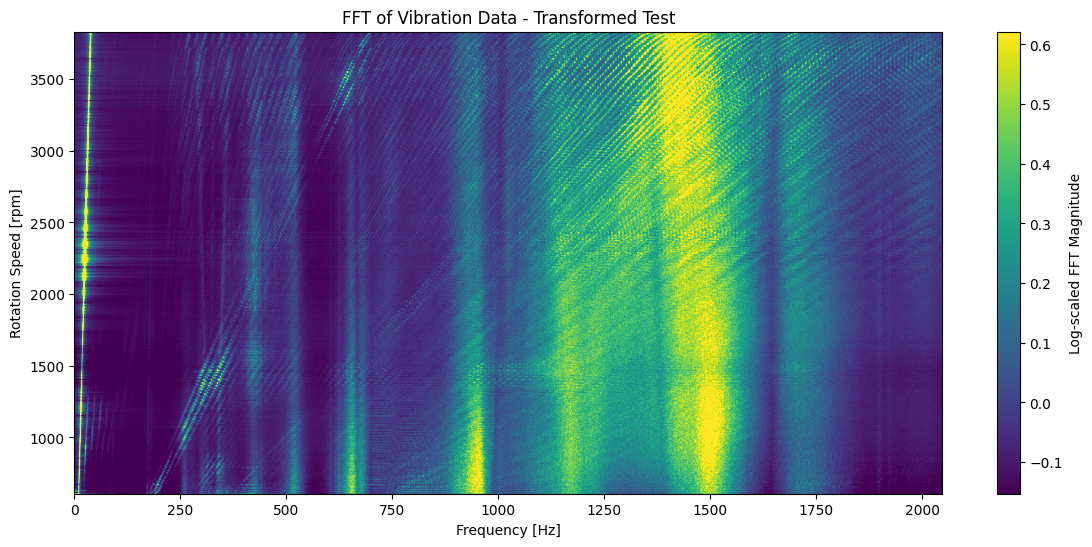

In [14]:
# Spectrogram erstellen
if not TESTING:
    data_frame=all_datasets[CONTROL_INDEX]
else:
    data_frame=transformed_test

vis.plot_fft_spectrogram(data_frame=data_frame, figsize=(14, 6))

In [15]:
# saving the preprocessed data
if not TESTING:

    for dataset in all_datasets:
        dl.save_dataset(dataset, uuid=UUID)

else:
    dl.save_dataset(transformed_test, uuid=UUID)

0D.csv successfully saved.
1D.csv successfully saved.
2D.csv successfully saved.
3D.csv successfully saved.
4D.csv successfully saved.
0E.csv successfully saved.
1E.csv successfully saved.
2E.csv successfully saved.
3E.csv successfully saved.
4E.csv successfully saved.


In [16]:
print(UUID)

4314cca1-2092-42e2-b281-3a4392706e6b
